# Домашнее задание к лекции «Алгоритмы кластеризации»

In [86]:
import cv2
import skimage
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from skimage.metrics import structural_similarity as ssim
from collections import defaultdict
from typing import List
from numpy.typing import ArrayLike


In [87]:
warnings.filterwarnings('ignore')

In [88]:
def draw_picture(image, title, bgr=False):
    b, g, r = cv2.split(image)
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(10, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.title(title)
    plt.show()


Исходное изображение

In [89]:
src_img = cv2.imread('D4V-voNWwAEMO31.jpeg')

Уменьшим исходное изображение, т.к. `AgglomerativeClustering` очень требователен к памяти

In [90]:
scale = 0.2
new_w = int(src_img.shape[1] * scale)
new_h = int(src_img.shape[0] * scale)
src_img = cv2.resize(src_img, (new_w, new_h), interpolation = cv2.INTER_AREA)

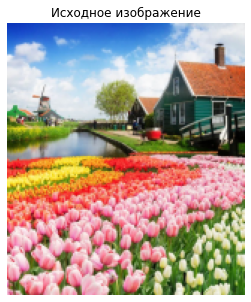

In [91]:
draw_picture(src_img, "Исходное изображение")

Получаем высоту и ширину изображения

In [92]:
h, w = src_img.shape[:2]

### DBSCAN

Для данной модели наилучший результат показал `eps` в районе 5

In [93]:
model = DBSCAN(eps=5)

Превращаем изображение в массив

In [94]:
img = src_img.reshape((src_img.shape[0] * src_img.shape[1], 3))

In [95]:
labels = model.fit_predict(img)

In [96]:
cluster_labels = model.labels_

Для облегчения вычислений напишем функции вычисления центроида и квантизатора

Функция центроида возвращает центроид для данного кластера

Функция квантизатора по массиву меток кластера создает массив соответствующих центроидов. Причем для класса `-1` (вне кластера) заполняется центроидом, вычисленным по всему изображению

In [97]:
def centroid(point: ArrayLike) -> List:
    point = np.array(point)
    length = point.shape[0]
    sum_r = np.sum(point[:,0])
    sum_g = np.sum(point[:,1])
    sum_b = np.sum(point[:,2])
    return [int(sum_r/length), int(sum_g/length), int(sum_b/length)]

def quantizator(img: ArrayLike, cluster_labels: ArrayLike, image_mean: List) -> ArrayLike:
    clusters = defaultdict(list)
    
    for i, l in enumerate(cluster_labels):
        clusters[l].append(img[i])
    
    unique_labels = set(cluster_labels)
    
    centroids = defaultdict(list)
    for l in unique_labels:
        if l == -1:
            centroids[l] = image_mean
        else:
            centroids[l] = centroid(clusters[l])
    
    quantized = []
    for l in cluster_labels:
        quantized.append(centroids[l])
    
    return np.array(quantized)


In [98]:
image_mean = centroid(img)
quantized = quantizator(img, cluster_labels, image_mean)

Количество кластеров

In [99]:
len(set(cluster_labels))

163

Превращаем массив обратно в прямоугольную картинку

In [100]:
new_img = quantized.reshape(h,w,3)

Вычисляем SSIM

In [101]:
score, _ = ssim(src_img, new_img, multichannel=True, full=True)

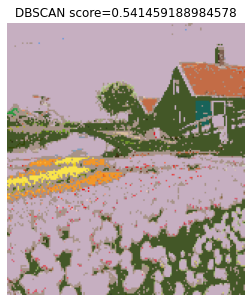

In [102]:
draw_picture(new_img, f"DBSCAN score={score}")

### KMeans

KMeans вычисляет центроиды, что упрощает квантизацию.
Получить центроиды можно с помощью аттрибута `cluster_centers_`

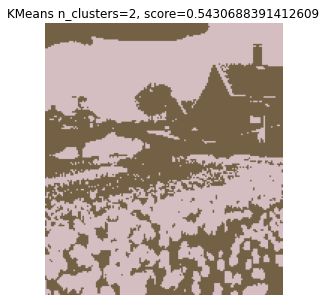

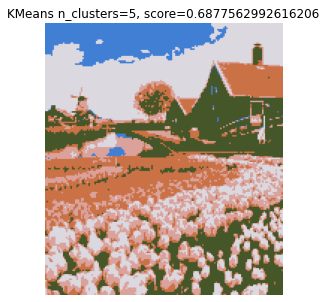

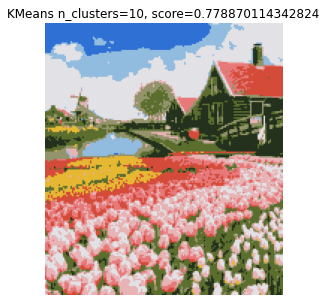

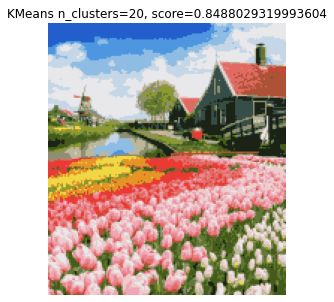

In [20]:
for n in [2, 5, 10, 20]:
    model = KMeans(n_clusters=n)
    labels = model.fit_predict(img)
    quantized = model.cluster_centers_.astype("uint8")[labels]
    new_img = quantized.reshape((h, w, 3))
    score, _ = ssim(src_img, new_img, multichannel=True, full=True)
    draw_picture(new_img, f"KMeans n_clusters={n}, score={score}")

### AgglomerativeClustering

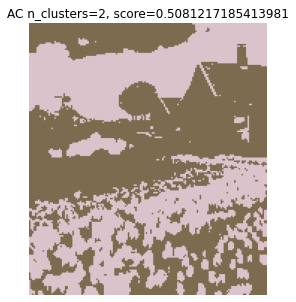

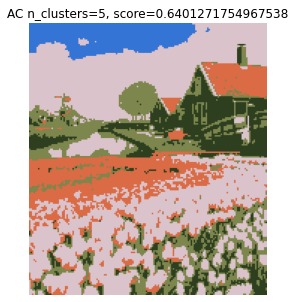

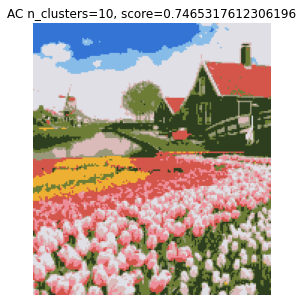

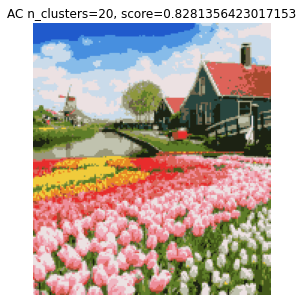

In [22]:
for n in [2,5,10,20]:
    model = AgglomerativeClustering(n_clusters=n)
    labels = model.fit_predict(img)
    quantized = quantizator(img, labels, image_mean)
    new_img = quantized.reshape(h,w,3)
    score, _ = ssim(src_img, new_img, multichannel=True, full=True)
    draw_picture(new_img, f"AC n_clusters={n}, score={score}")

### Выводы
| Модель      | SSIM  |
|-------------|-------|
| KMeans n=20 | 0.849 |
| AC n=20     | 0.828 |
| KMeans n=10 | 0.779 |
| AC n=10     | 0.747 |
| KMeans n=5  | 0.688 |
| AC n=5      | 0.640 |
| KMeans n=2  | 0.543 |
| DBSCAN      | 0.541 |
| AC n=5      | 0.508 |

KMeans для любого количества кластеров дает результат лучше AC, с учетом того, что AC на порядок медленней и очень требователен к объему памяти.

DBSCAN справился практически хуже всех, очень много точек не было отнесено ни к какому кластеру несмотря на подгонку `eps` и заполнения "выпавших" точек глобальным средним при этом количество кластеров получилось в количестве 162 (за вычетом -1).